In [9]:
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import glob

from oil.utils import to_var_gpu
from oil.cnnTrainer import CnnTrainer
from oil.datasets import CIFAR10, C10augLayers
from oil.networkparts import layer13
from oil.schedules import cosLr, sigmoidConsRamp
from oil.calibration import getLogitsAndLabels, get_logit_mean_std, max_logit_calib_rule, get_temperature, evaluate_ECE
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
savedir = None
load_path = '/home/maf388/tb-experiments/layer13s5000dev/'

total_epochs = 250
opt_constr = lambda params, base_lr: optim.SGD(params, base_lr, .9, weight_decay=1e-4, nesterov=True)
lr_lambda = cosLr(total_epochs, 1)

config = {'base_lr':.1, 'amntLab':1, 'amntDev':5000,
          'lab_BS':50, 'ul_BS':50, 'num_workers':4,
          'lr_lambda':lr_lambda, 'opt_constr':opt_constr,
          'log':False,
          }

fullCNN = nn.Sequential(C10augLayers(),layer13(numClasses=10))
datasets = CIFAR10(aug=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainer = CnnTrainer(fullCNN, datasets, savedir, load_path+'net0.ckpt', **config)

Creating Train, Dev split         with 45000 Train and 5000 Dev
=> loading checkpoint '/home/maf388/tb-experiments/layer13s5000dev/net0.ckpt'


In [10]:
dev_logits_list = []
test_logits_list = []
for path in glob.glob(load_path+'*.ckpt'):
    trainer.load_checkpoint(path)
    neti_logits = getLogitsAndLabels(trainer.CNN, trainer.dev)[0]
    dev_logits_list.append(neti_logits)
    test_neti_logits = getLogitsAndLabels(trainer.CNN, trainer.test)[0]
    test_logits_list.append(test_neti_logits)

dev_labels = getLogitsAndLabels(trainer.CNN, trainer.dev)[1]
test_labels = getLogitsAndLabels(trainer.CNN, trainer.test)[1]
print("{} ensembles loaded".format(len(dev_logits_list)))

=> loading checkpoint '/home/maf388/tb-experiments/layer13s5000dev/net0.ckpt'
=> loading checkpoint '/home/maf388/tb-experiments/layer13s5000dev/net1.ckpt'
=> loading checkpoint '/home/maf388/tb-experiments/layer13s5000dev/net2.ckpt'
=> loading checkpoint '/home/maf388/tb-experiments/layer13s5000dev/net3.ckpt'
=> loading checkpoint '/home/maf388/tb-experiments/layer13s5000dev/net4.ckpt'
=> loading checkpoint '/home/maf388/tb-experiments/layer13s5000dev/net5.ckpt'
=> loading checkpoint '/home/maf388/tb-experiments/layer13s5000dev/net6.ckpt'
7 ensembles loaded


In [75]:
max_ps_list_dev = list(map(lambda dev_logits: F.softmax(dev_logits, dim=1).max(1)[0],dev_logits_list))
max_ls_list_dev = list(map(lambda dev_logits: dev_logits.max(1)[0],dev_logits_list))
max_ps_list_test = list(map(lambda test_logits: F.softmax(test_logits, dim=1).max(1)[0],test_logits_list))
max_ls_list_test = list(map(lambda test_logits: test_logits.max(1)[0],test_logits_list))

In [76]:
def getThresholds(percentile, data_list):
    getThresh = lambda data: np.percentile(data.cpu().data.numpy(),percentile)
    return list(map(getThresh, data_list))

In [96]:
def getRejectOverlap(data_list, percentile, k):
    thresholds = getThresholds(percentile, data_list)
    allRejected = np.ones(len(data_list[0]));# print("Total data: {}".format(len(data_list[0])))
    for i in range(k):
        allRejected *= (data_list[i].cpu().data.numpy()<thresholds[i])
    return allRejected.mean()

In [97]:
getRejectOverlap(max_ps_list_test, 10, 5)

0.0318

Text(0,0.5,'All rejected')

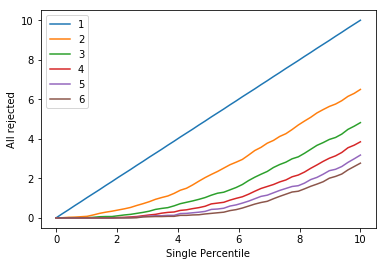

In [108]:
numThresholds = 50
reject_rates = np.linspace(0,10,numThresholds)
overlaps = []
for k in range(1,7):
    overlap = np.zeros(numThresholds)
    for i, percent in enumerate(reject_rates):
        overlap[i] = getRejectOverlap(max_ps_list_test, percent, k)
    overlaps.append(overlap)
labels = []
for k, overlap in enumerate(overlaps):
    plt.plot(reject_rates, 100*overlap)
    labels.append(str(k+1))
plt.legend(labels)
plt.xlabel("Single Percentile")
plt.ylabel("All rejected")

In [412]:
def getEnsembleAcc(data_list, percentile, k):
    n = len(test_labels)
    thresholds = getThresholds(percentile, data_list)
    probs = np.zeros((n,10))
    allRejected = np.ones(n).astype(np.bool)
    ensembleCounter = np.zeros(n)
    for i in range(k):
        neti_rejects = (data_list[i].cpu().data.numpy()<thresholds[i])
        probsi = F.softmax(test_logits_list[i],dim=1).cpu().data.numpy()
        allRejected &= neti_rejects
        probs[~neti_rejects] += probsi[~neti_rejects]
        ensembleCounter[~neti_rejects] +=1
        #assert np.all(allRejected==neti_rejects)
    for i in range(k):
        probsi = F.softmax(test_logits_list[i],dim=1).cpu().data.numpy()
        probs[allRejected] += probsi[allRejected]
        ensembleCounter[allRejected] +=1
    assert np.all(ensembleCounter>0), "not all counted"
    probs/=ensembleCounter[:,None]
    whereCorrect = np.argmax(probs, axis=1)[~allRejected]==test_labels.cpu().data.numpy()[~allRejected]
    acc = np.mean(whereCorrect)
    return acc, whereCorrect, (allRejected).mean()

In [351]:
print(getEnsembleAcc(max_ps_list_test, 4,7)[0])
print(getOracleAcc(7)[0])

0.9530671470029021
0.9788


In [359]:
print(getEnsembleAcc(max_ps_list_test, 5,1)[0])

(10000, 10)
0.9677894736842105


In [345]:
rejection_setpoints = np.linspace(0,25,10)

1th network
2th network
3th network
4th network
5th network
6th network
7th network


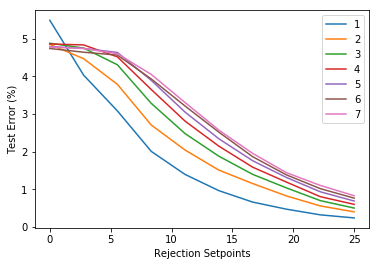

In [413]:
labels = []
for k in range(1,8):   
    accs = np.zeros_like(rejection_setpoints)
    reject_rates = np.zeros_like(rejection_setpoints)
    print("{}th network".format(k))
    for i,setpoint in enumerate(rejection_setpoints):
        accs[i], _, reject_rates[i] = getEnsembleAcc(max_ps_list_test, setpoint, k)
    plt.plot(rejection_setpoints, 100*(1-accs))
    labels.append(str(k))
plt.xlabel("Rejection Setpoints")
plt.ylabel("Test Error (%)")
plt.legend(labels)

In [ ]:
plt.xlabel("Rejection Rate")
plt.ylabel("Test Error (%)")
plt.plot(reject_ratesL, 100*(1-accsL),color='green')
plt.plot(reject_ratesP, 100*(1-accsP),color='blue')
plt.legend(["Maximum logit rejection", "Maximum prob rejection"])

In [285]:
def getOracleAcc(k):
    n = len(test_labels)
    probs = np.zeros((n,10))
    allRejected = np.ones(n).astype(np.bool)
    ensembleCounter = np.zeros(n)
    for i in range(k):
        neti_rejects = ~(test_logits_list[i].max(1)[1].eq(test_labels).cpu().data.numpy()).astype(np.bool)
        probsi = F.softmax(test_logits_list[i],dim=1).cpu().data.numpy()
        allRejected &= neti_rejects
        probs += probsi*(~neti_rejects)[:,None]
        ensembleCounter[~neti_rejects]+=1
    for i in range(k):
        probsi = F.softmax(test_logits_list[i],dim=1).cpu().data.numpy()
        probs[allRejected] += probsi[allRejected]
        ensembleCounter[allRejected]+=1
    probs/=ensembleCounter[:,None]
    whereCorrect = np.argmax(probs, axis=1)==test_labels.cpu().data.numpy()
    acc = np.mean(whereCorrect)
    return acc, whereCorrect

In [290]:
k=2
percentile = 10
accOracle, whereOracleCorrect = getOracleAcc(2)
accEns, whereEnsembleCorrect = getEnsembleAcc(max_ls_list_test,percentile,2)

In [291]:
shouldHave = (~whereEnsembleCorrect) & whereOracleCorrect

12.313720893859864
12.607242965698243


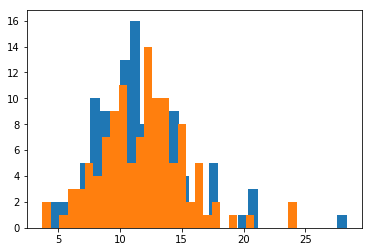

In [297]:
for i in range(k):
    shouldHaveLogits = max_ls_list_test[i].cpu().data.numpy()[shouldHave]
    print(np.percentile(max_ls_list_test[i].cpu().data.numpy(),percentile))
    plt.hist(shouldHaveLogits,bins=30)

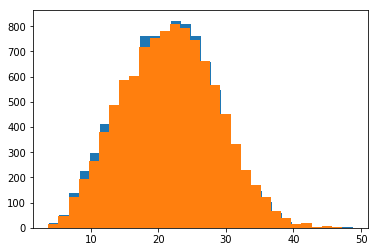

In [293]:
for i in range(k):
    logits = max_ls_list_test[i].cpu().data.numpy()
    plt.hist(logits,bins=30)